## Testing hypothesis 3 in a Big Data context using PySpark
---

**_Hypothesis_**: Reviews with higher book rating have higher helpfulness ratings.

   - **Metric**: Correlation between helpfulness_score book ratings.

**Missing Values**:

  - `review/score`: remove the entire sample
  - `Tot_votes`: remove the entire sample

**Data Transformation**:
  - `review/score`: groupBy book ratings and calculate the average score.
  - `review/helpfulness`: $helpfulness = \frac{x}{y} \sqrt(y)$

---

In [1]:
# Initialize spark
import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("hypothesis_3").getOrCreate()

23/09/13 15:24:20 WARN Utils: Your hostname, MacBook-Pro-di-Andrea.local resolves to a loopback address: 127.0.0.1; using 192.168.1.148 instead (on interface en0)
23/09/13 15:24:20 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/09/13 15:24:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/09/13 15:24:21 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/09/13 15:24:21 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [87]:
# Import libraries
from pyspark.sql.functions import *
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt


In [3]:
# Define the schema
ratings_schema = StructType([
    StructField("Title", StringType(), True),
    StructField("Price", FloatType(), True),
    StructField("User_id", IntegerType(), True),
    StructField("profileName", StringType(), True),
    StructField("review/score", FloatType(), True),
    StructField("review/time", IntegerType(), True),
    StructField("review/summary", StringType(), True),
    StructField("review/text", StringType(), True),
    StructField("N_helpful", IntegerType(), True),
    StructField("Tot_votes", IntegerType(), True)
])

# Load the data
df_ratings = spark.read.csv('hdfs://localhost:9900/user/book_reviews/books_rating_cleaned.csv', header=True, schema=ratings_schema, sep='\t')
df_ratings.show(5)

In [77]:
# Filter out the data
df_ratings_filtered = df_ratings.filter(df_ratings['review/score'].isNotNull())
df_ratings_filtered = df_ratings_filtered.filter(df_ratings_filtered['Tot_votes'] > 20)

# Add the helpfulness ratio column
df_ratings_filtered = df_ratings_filtered.withColumn('helpfulness_ratio', df_ratings_filtered['N_helpful']/df_ratings_filtered['Tot_votes']*sqrt(df_ratings_filtered['Tot_votes']))

# Retain only the required columns
df_ratings_selected = df_ratings_filtered.select('review/score', 'helpfulness_ratio')

# Compute the spearman correlation (it requires Mlib to work with DataFrame API)
vector_col = VectorAssembler(inputCols=df_ratings_selected.columns, outputCol='features')
dataset = vector_col.transform(df_ratings_selected).select('features')
corr = Correlation.corr(dataset, 'features', method='spearman').collect()[0][0].toArray()[0][1]
print(f'The Spearman correlation coefficient is {round(corr,2)}')

The Spearman correlation coefficient is 0.52714676795988


<AxesSubplot: title={'center': 'Average helpfulness ratio per score'}, xlabel='review/score'>

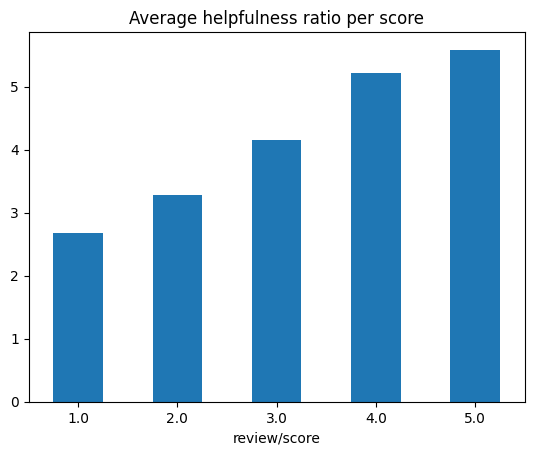

In [96]:
# Plot the results
df_grouped = df_ratings_selected.groupBy('review/score').agg(avg('helpfulness_ratio'))
df_grouped = df_grouped.sort('review/score')
#df_grouped.plot.bar(x='review/score', y='avg(helpfulness_ratio)', rot=0, title='Average helpfulness ratio per score')

df_pandas = df_grouped.toPandas()
plt.figure(figsize=(10,5))
df_pandas.plot.bar(x='review/score', y='avg(helpfulness_ratio)', rot=0, title='Average helpfulness ratio per score', legend = False)
